# READ

1. API is in User Variables for User in Environemtn Variables named "NEPTUNE_API_TOKEN"
2. If internet sucks, set mode to offline
4. When offline runs are saved locally, sync it with | neptune sync -p "New-Thesis/KFold-Test" --offline-only |
- make sure it is in venv mode | (venv) PS C:\Users\user\Documents\Machine-Learning-Hub-1\ImageClassification\Neptune-Thesis> |
5. Delete the offline folder or use | neptune clear |

# Load Libraries

In [1]:
import tqdm
import os
import cv2
import imghdr
import image_to_numpy
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
import itertools
from numpy.random import default_rng

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomBrightness, Rescaling, Resizing
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.metrics import F1Score, Precision, Recall, CategoricalAccuracy
from tensorboard.plugins.hparams import api as hp
import sklearn
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import StratifiedKFold

from time import perf_counter
import math

import neptune
from neptune.integrations.tensorflow_keras import NeptuneCallback

# Initialize Functions

In [2]:
model_name = "V4.1.3"
checkpoint_path = f'./checkpoints/{model_name}/FOLD-'

In [4]:
def make_model(params):
    model = Sequential()
    model.add(RandomFlip(mode='horizontal', seed=1, input_shape=(256,256,3)))
    model.add(RandomRotation(factor=0.2, seed=1))
    
    model.add(Conv2D(input_shape=(256,256,3), filters=16, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())
    
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())
    
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())
    
    model.add(Flatten())
    model.add(Dropout(0.2, seed=1))
    model.add(Dense(units=384,activation="relu"))
    model.add(Dropout(0.2, seed=1))
    model.add(Dense(units=256,activation="relu"))
    
    model.add(Dense(units=4, activation="softmax"))


    optimizer = tf.keras.optimizers.Adam(
        learning_rate=params["lr"],
    )
    
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
def create_callbacks(counter):
    neptune_cbk = NeptuneCallback(run=run, base_namespace="training")

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path + str(counter), 
                                                                 monitor='val_loss', 
                                                                 mode='auto', 
                                                                 save_best_only=True, 
                                                                 verbose=1)
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                   patience=23,
                                                  )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                         factor=0.6, 
                                                         patience=15, 
                                                         min_delta=0.001, 
                                                         mode='auto', 
                                                         verbose=1)
    return [neptune_cbk, reduce_lr, cp_callback, es_callback]

In [6]:
def plot_loss(hist):
    fig = plt.figure(figsize=(3,2))
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    plt.suptitle('Loss')
    plt.legend(loc='upper right')
    plt.show()
    return fig

In [7]:
def plot_acc(hist):
    fig = plt.figure(figsize=(3,2))
    plt.plot(hist.history['accuracy'], color='teal', label='acc')
    plt.plot(hist.history['val_accuracy'], color='orange', label='val_acc')
    plt.suptitle('Accuracy')
    plt.legend(loc='upper left')
    plt.show()
    return fig

In [8]:
def avg_rate(metric_list):
    return sum(metric_list) / len(metric_list)

# Prepare Dataset

In [9]:
labels = ['Building', 'Plant', 'Road', 'Vehicle']
X_train = []
y_train = []
y_label_idx = []
image_size = 256
for i in labels:
    folderPath = os.path.join('D:\DATASETS\For-Thesis\Labels', i)
    for j in os.listdir(folderPath):
        img = image_to_numpy.load_image_file(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_label_idx.append(labels.index(i))

In [10]:
X_train = np.array(X_train)
y_label_idx = np.array(y_label_idx)

X_train_scaled = X_train.astype(np.float32) / 255.0

In [11]:
rng = default_rng(seed=1)

buildings_test_idx = rng.choice(np.arange(0,600), size=120, replace=False)
plants_test_idx = rng.choice(np.arange(600,1200), size=120, replace=False)
roads_test_idx = rng.choice(np.arange(1200,1800), size=120, replace=False)
vehicles_test_idx = rng.choice(np.arange(1800,2400), size=120, replace=False)
total_test_idx = np.concatenate((buildings_test_idx, plants_test_idx, roads_test_idx, vehicles_test_idx), axis=None)

In [12]:
def train_test_X(X_train_scaled):    
    test_x = X_train_scaled[total_test_idx]
    train_x = np.delete(X_train_scaled, total_test_idx, axis=0)
    return train_x, test_x

def train_test_y(y_label_idx):
    test_y = y_label_idx[total_test_idx]
    train_y = np.delete(y_label_idx, total_test_idx, axis=0)
    return train_y, test_y

In [13]:
train_x, holdout_x = train_test_X(X_train_scaled)
train_y, holdout_y = train_test_y(y_label_idx)

In [14]:
print(len(train_x), len(holdout_x))

1920 480


In [15]:
print(train_y[:5])

[0 0 0 0 0]


In [16]:
# Inidices remain the same thanks to the seed (set to 1)
# with open('total_test_idx.txt', 'w+') as f:
     
#     # write elements of list
#     for items in total_test_idx:
#         f.write('%s ' %items)
     
#     print("File written successfully")
 
 
# # close the file
# f.close()

# Run KFOLD

In [17]:
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=1)

In [18]:
project_name = "New-Thesis/KFold-Test"
# api_token = <It is already initialized in environemnt variables>
params = {
    "lr": 0.001, 
    "epochs": 55, 
    "batch_size": 8}

In [19]:
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING

[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: offline/2dad8746-9cd5-41ce-a51f-469a98542573


Epoch 1/55


210/210 [==============================] - ETA: 0s - loss: 6.4274 - accuracy: 0.5488
Epoch 1: val_loss improved from inf to 4.40026, saving model to ./checkpoints/V4.1.3\FOLD-0
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-0\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-0\assets


210/210 [==============================] - 137s 504ms/step - loss: 6.4274 - accuracy: 0.5488 - val_loss: 4.4003 - val_accuracy: 0.2958 - lr: 0.0010
Epoch 2/55
210/210 [==============================] - ETA: 0s - loss: 1.0232 - accuracy: 0.6060
Epoch 2: val_loss improved from 4.40026 to 1.22267, saving model to ./checkpoints/V4.1.3\FOLD-0
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-0\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-0\assets


210/210 [==============================] - 113s 540ms/step - loss: 1.0232 - accuracy: 0.6060 - val_loss: 1.2227 - val_accuracy: 0.4375 - lr: 0.0010
Epoch 3/55
210/210 [==============================] - ETA: 0s - loss: 0.8541 - accuracy: 0.6399
Epoch 3: val_loss improved from 1.22267 to 0.58597, saving model to ./checkpoints/V4.1.3\FOLD-0
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-0\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-0\assets


210/210 [==============================] - 89s 422ms/step - loss: 0.8541 - accuracy: 0.6399 - val_loss: 0.5860 - val_accuracy: 0.7583 - lr: 0.0010
Epoch 4/55
210/210 [==============================] - ETA: 0s - loss: 0.8923 - accuracy: 0.6286
Epoch 4: val_loss did not improve from 0.58597
210/210 [==============================] - 82s 392ms/step - loss: 0.8923 - accuracy: 0.6286 - val_loss: 1.1844 - val_accuracy: 0.4458 - lr: 0.0010
Epoch 5/55
210/210 [==============================] - ETA: 0s - loss: 0.8460 - accuracy: 0.6143
Epoch 5: val_loss did not improve from 0.58597
210/210 [==============================] - 83s 393ms/step - loss: 0.8460 - accuracy: 0.6143 - val_loss: 1.0662 - val_accuracy: 0.5958 - lr: 0.0010
Epoch 6/55
210/210 [==============================] - ETA: 0s - loss: 0.9359 - accuracy: 0.6179
Epoch 6: val_loss did not improve from 0.58597
210/210 [==============================] - 82s 392ms/step - loss: 0.9359 - accuracy: 0.6179 - val_loss: 1.1281 - val_accuracy: 0.4

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-0\assets


210/210 [==============================] - 89s 424ms/step - loss: 0.7241 - accuracy: 0.7065 - val_loss: 0.5632 - val_accuracy: 0.7792 - lr: 0.0010
Epoch 12/55
210/210 [==============================] - ETA: 0s - loss: 0.7967 - accuracy: 0.6911
Epoch 12: val_loss did not improve from 0.56317
210/210 [==============================] - 83s 393ms/step - loss: 0.7967 - accuracy: 0.6911 - val_loss: 1.4642 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 13/55
210/210 [==============================] - ETA: 0s - loss: 0.7539 - accuracy: 0.7119
Epoch 13: val_loss did not improve from 0.56317
210/210 [==============================] - 83s 393ms/step - loss: 0.7539 - accuracy: 0.7119 - val_loss: 1.1864 - val_accuracy: 0.6750 - lr: 0.0010
Epoch 14/55
210/210 [==============================] - ETA: 0s - loss: 0.7850 - accuracy: 0.7125
Epoch 14: val_loss did not improve from 0.56317
210/210 [==============================] - 82s 393ms/step - loss: 0.7850 - accuracy: 0.7125 - val_loss: 1.5373 - val_accurac

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-0\assets


210/210 [==============================] - 89s 423ms/step - loss: 0.5906 - accuracy: 0.7887 - val_loss: 0.4123 - val_accuracy: 0.8375 - lr: 0.0010
Epoch 27/55
210/210 [==============================] - ETA: 0s - loss: 0.5833 - accuracy: 0.7762
Epoch 27: val_loss did not improve from 0.41231
210/210 [==============================] - 83s 393ms/step - loss: 0.5833 - accuracy: 0.7762 - val_loss: 3.6773 - val_accuracy: 0.3417 - lr: 0.0010
Epoch 28/55
210/210 [==============================] - ETA: 0s - loss: 0.6012 - accuracy: 0.7714
Epoch 28: val_loss did not improve from 0.41231
210/210 [==============================] - 83s 393ms/step - loss: 0.6012 - accuracy: 0.7714 - val_loss: 0.6401 - val_accuracy: 0.7375 - lr: 0.0010
Epoch 29/55
210/210 [==============================] - ETA: 0s - loss: 0.6139 - accuracy: 0.7690
Epoch 29: val_loss did not improve from 0.41231
210/210 [==============================] - 82s 390ms/step - loss: 0.6139 - accuracy: 0.7690 - val_loss: 1.2384 - val_accurac

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-0\assets


210/210 [==============================] - 88s 420ms/step - loss: 0.5115 - accuracy: 0.8036 - val_loss: 0.3780 - val_accuracy: 0.8708 - lr: 0.0010
Epoch 36/55
210/210 [==============================] - ETA: 0s - loss: 0.5046 - accuracy: 0.8024
Epoch 36: val_loss did not improve from 0.37803
210/210 [==============================] - 82s 393ms/step - loss: 0.5046 - accuracy: 0.8024 - val_loss: 0.5861 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 37/55
210/210 [==============================] - ETA: 0s - loss: 0.4911 - accuracy: 0.8202
Epoch 37: val_loss did not improve from 0.37803
210/210 [==============================] - 82s 391ms/step - loss: 0.4911 - accuracy: 0.8202 - val_loss: 0.5547 - val_accuracy: 0.7875 - lr: 0.0010
Epoch 38/55
210/210 [==============================] - ETA: 0s - loss: 0.4901 - accuracy: 0.8089
Epoch 38: val_loss did not improve from 0.37803
210/210 [==============================] - 82s 393ms/step - loss: 0.4901 - accuracy: 0.8089 - val_loss: 1.7711 - val_accurac

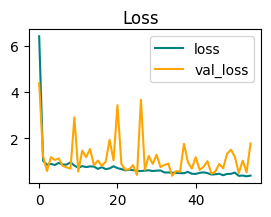

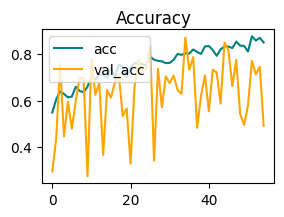

Fold Training Time: 1 hour(s) and 17 mins
Precision: 89.99999761581421  -  Recall: 82.4999988079071
Accuracy: 87.08333373069763
F1Score: Building 79.06977844238281 | Plant 92.43697357177734 | Road 97.4358901977539 | Vehicle 80.0
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/32683ae2-577c-4d78-82f3-ddb9e8129f05
Epoch 1/55
210/210 [==============================] - ETA: 0s - loss: 7.6314 - accuracy: 0.5393
Epoch 1: val_loss improved from inf to 2.33086, saving model to ./checkpoints/V4.1.3\FOLD-1
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-1\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-1\assets


210/210 [==============================] - 95s 432ms/step - loss: 7.6314 - accuracy: 0.5393 - val_loss: 2.3309 - val_accuracy: 0.3542 - lr: 0.0010
Epoch 2/55
210/210 [==============================] - ETA: 0s - loss: 0.8900 - accuracy: 0.6452
Epoch 2: val_loss improved from 2.33086 to 1.13981, saving model to ./checkpoints/V4.1.3\FOLD-1
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-1\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-1\assets


210/210 [==============================] - 88s 420ms/step - loss: 0.8900 - accuracy: 0.6452 - val_loss: 1.1398 - val_accuracy: 0.4500 - lr: 0.0010
Epoch 3/55
210/210 [==============================] - ETA: 0s - loss: 0.8336 - accuracy: 0.6560
Epoch 3: val_loss did not improve from 1.13981
210/210 [==============================] - 82s 392ms/step - loss: 0.8336 - accuracy: 0.6560 - val_loss: 1.2248 - val_accuracy: 0.5542 - lr: 0.0010
Epoch 4/55
210/210 [==============================] - ETA: 0s - loss: 0.8730 - accuracy: 0.6583
Epoch 4: val_loss did not improve from 1.13981
210/210 [==============================] - 82s 392ms/step - loss: 0.8730 - accuracy: 0.6583 - val_loss: 4.0689 - val_accuracy: 0.5042 - lr: 0.0010
Epoch 5/55
210/210 [==============================] - ETA: 0s - loss: 0.7915 - accuracy: 0.7000
Epoch 5: val_loss did not improve from 1.13981
210/210 [==============================] - 82s 391ms/step - loss: 0.7915 - accuracy: 0.7000 - val_loss: 1.4481 - val_accuracy: 0.5

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-1\assets


210/210 [==============================] - 88s 418ms/step - loss: 0.8789 - accuracy: 0.6458 - val_loss: 0.6256 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 7/55
210/210 [==============================] - ETA: 0s - loss: 0.7428 - accuracy: 0.6845
Epoch 7: val_loss did not improve from 0.62561
210/210 [==============================] - 82s 390ms/step - loss: 0.7428 - accuracy: 0.6845 - val_loss: 2.7741 - val_accuracy: 0.3875 - lr: 0.0010
Epoch 8/55
210/210 [==============================] - ETA: 0s - loss: 0.8617 - accuracy: 0.6554
Epoch 8: val_loss improved from 0.62561 to 0.60748, saving model to ./checkpoints/V4.1.3\FOLD-1
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-1\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-1\assets


210/210 [==============================] - 89s 422ms/step - loss: 0.8617 - accuracy: 0.6554 - val_loss: 0.6075 - val_accuracy: 0.7750 - lr: 0.0010
Epoch 9/55
210/210 [==============================] - ETA: 0s - loss: 0.9187 - accuracy: 0.6577
Epoch 9: val_loss did not improve from 0.60748
210/210 [==============================] - 83s 393ms/step - loss: 0.9187 - accuracy: 0.6577 - val_loss: 1.3443 - val_accuracy: 0.3958 - lr: 0.0010
Epoch 10/55
210/210 [==============================] - ETA: 0s - loss: 0.8274 - accuracy: 0.6738
Epoch 10: val_loss did not improve from 0.60748
210/210 [==============================] - 82s 392ms/step - loss: 0.8274 - accuracy: 0.6738 - val_loss: 0.8783 - val_accuracy: 0.7167 - lr: 0.0010
Epoch 11/55
210/210 [==============================] - ETA: 0s - loss: 0.9127 - accuracy: 0.6357
Epoch 11: val_loss did not improve from 0.60748
210/210 [==============================] - 83s 393ms/step - loss: 0.9127 - accuracy: 0.6357 - val_loss: 1.0778 - val_accuracy:

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-1\assets


210/210 [==============================] - 88s 421ms/step - loss: 0.6655 - accuracy: 0.7625 - val_loss: 0.4591 - val_accuracy: 0.8333 - lr: 6.0000e-04
Epoch 25/55
210/210 [==============================] - ETA: 0s - loss: 0.5978 - accuracy: 0.7774
Epoch 25: val_loss did not improve from 0.45915
210/210 [==============================] - 82s 393ms/step - loss: 0.5978 - accuracy: 0.7774 - val_loss: 0.5903 - val_accuracy: 0.7750 - lr: 6.0000e-04
Epoch 26/55
210/210 [==============================] - ETA: 0s - loss: 0.5643 - accuracy: 0.7863
Epoch 26: val_loss did not improve from 0.45915
210/210 [==============================] - 83s 394ms/step - loss: 0.5643 - accuracy: 0.7863 - val_loss: 0.8470 - val_accuracy: 0.7125 - lr: 6.0000e-04
Epoch 27/55
210/210 [==============================] - ETA: 0s - loss: 0.5478 - accuracy: 0.7911
Epoch 27: val_loss did not improve from 0.45915
210/210 [==============================] - 82s 393ms/step - loss: 0.5478 - accuracy: 0.7911 - val_loss: 0.4609 -

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-1\assets


210/210 [==============================] - 89s 423ms/step - loss: 0.4973 - accuracy: 0.8077 - val_loss: 0.4060 - val_accuracy: 0.8500 - lr: 6.0000e-04
Epoch 38/55
210/210 [==============================] - ETA: 0s - loss: 0.4775 - accuracy: 0.8077
Epoch 38: val_loss did not improve from 0.40605
210/210 [==============================] - 83s 394ms/step - loss: 0.4775 - accuracy: 0.8077 - val_loss: 0.7394 - val_accuracy: 0.6875 - lr: 6.0000e-04
Epoch 39/55
210/210 [==============================] - ETA: 0s - loss: 0.4670 - accuracy: 0.8256
Epoch 39: val_loss did not improve from 0.40605
210/210 [==============================] - 83s 393ms/step - loss: 0.4670 - accuracy: 0.8256 - val_loss: 0.8673 - val_accuracy: 0.6500 - lr: 6.0000e-04
Epoch 40/55
210/210 [==============================] - ETA: 0s - loss: 0.5503 - accuracy: 0.7875
Epoch 40: val_loss did not improve from 0.40605
210/210 [==============================] - 83s 394ms/step - loss: 0.5503 - accuracy: 0.7875 - val_loss: 2.5295 -

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-1\assets


210/210 [==============================] - 89s 422ms/step - loss: 0.4863 - accuracy: 0.8101 - val_loss: 0.3829 - val_accuracy: 0.8500 - lr: 6.0000e-04
Epoch 42/55
210/210 [==============================] - ETA: 0s - loss: 0.4512 - accuracy: 0.8196
Epoch 42: val_loss did not improve from 0.38285
210/210 [==============================] - 83s 395ms/step - loss: 0.4512 - accuracy: 0.8196 - val_loss: 0.5228 - val_accuracy: 0.8125 - lr: 6.0000e-04
Epoch 43/55
210/210 [==============================] - ETA: 0s - loss: 0.4519 - accuracy: 0.8137
Epoch 43: val_loss did not improve from 0.38285
210/210 [==============================] - 83s 393ms/step - loss: 0.4519 - accuracy: 0.8137 - val_loss: 0.4527 - val_accuracy: 0.8167 - lr: 6.0000e-04
Epoch 44/55
210/210 [==============================] - ETA: 0s - loss: 0.4224 - accuracy: 0.8327
Epoch 44: val_loss did not improve from 0.38285
210/210 [==============================] - 84s 399ms/step - loss: 0.4224 - accuracy: 0.8327 - val_loss: 0.4463 -

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-1\assets


210/210 [==============================] - 89s 422ms/step - loss: 0.4228 - accuracy: 0.8375 - val_loss: 0.3715 - val_accuracy: 0.8583 - lr: 6.0000e-04
Epoch 49/55
210/210 [==============================] - ETA: 0s - loss: 0.5195 - accuracy: 0.8006
Epoch 49: val_loss did not improve from 0.37153
210/210 [==============================] - 82s 392ms/step - loss: 0.5195 - accuracy: 0.8006 - val_loss: 0.4689 - val_accuracy: 0.8292 - lr: 6.0000e-04
Epoch 50/55
210/210 [==============================] - ETA: 0s - loss: 0.4468 - accuracy: 0.8202
Epoch 50: val_loss did not improve from 0.37153
210/210 [==============================] - 82s 392ms/step - loss: 0.4468 - accuracy: 0.8202 - val_loss: 0.4561 - val_accuracy: 0.8417 - lr: 6.0000e-04
Epoch 51/55
210/210 [==============================] - ETA: 0s - loss: 0.4341 - accuracy: 0.8268
Epoch 51: val_loss did not improve from 0.37153
210/210 [==============================] - 83s 393ms/step - loss: 0.4341 - accuracy: 0.8268 - val_loss: 0.6275 -

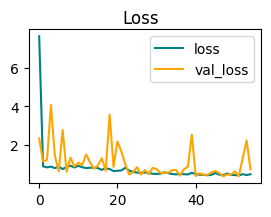

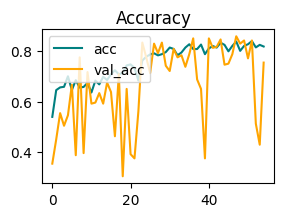

Fold Training Time: 1 hour(s) and 16 mins
Precision: 86.5217387676239  -  Recall: 82.91666507720947
Accuracy: 85.83333492279053
F1Score: Building 78.9916000366211 | Plant 90.76923370361328 | Road 92.85714721679688 | Vehicle 80.67227172851562
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/959e4742-f29e-4327-ad9a-4e8d8923c307
Epoch 1/55
210/210 [==============================] - ETA: 0s - loss: 6.3124 - accuracy: 0.5524
Epoch 1: val_loss improved from inf to 1.78243, saving model to ./checkpoints/V4.1.3\FOLD-2
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-2\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-2\assets


210/210 [==============================] - 95s 428ms/step - loss: 6.3124 - accuracy: 0.5524 - val_loss: 1.7824 - val_accuracy: 0.2625 - lr: 0.0010
Epoch 2/55
210/210 [==============================] - ETA: 0s - loss: 0.9557 - accuracy: 0.6060
Epoch 2: val_loss improved from 1.78243 to 1.14141, saving model to ./checkpoints/V4.1.3\FOLD-2
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-2\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-2\assets


210/210 [==============================] - 89s 423ms/step - loss: 0.9557 - accuracy: 0.6060 - val_loss: 1.1414 - val_accuracy: 0.4917 - lr: 0.0010
Epoch 3/55
210/210 [==============================] - ETA: 0s - loss: 0.8828 - accuracy: 0.6149
Epoch 3: val_loss improved from 1.14141 to 1.04770, saving model to ./checkpoints/V4.1.3\FOLD-2
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-2\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-2\assets


210/210 [==============================] - 93s 443ms/step - loss: 0.8828 - accuracy: 0.6149 - val_loss: 1.0477 - val_accuracy: 0.5250 - lr: 0.0010
Epoch 4/55
210/210 [==============================] - ETA: 0s - loss: 0.8567 - accuracy: 0.6304
Epoch 4: val_loss did not improve from 1.04770
210/210 [==============================] - 83s 394ms/step - loss: 0.8567 - accuracy: 0.6304 - val_loss: 2.6623 - val_accuracy: 0.3958 - lr: 0.0010
Epoch 5/55
210/210 [==============================] - ETA: 0s - loss: 0.7797 - accuracy: 0.6685
Epoch 5: val_loss did not improve from 1.04770
210/210 [==============================] - 82s 392ms/step - loss: 0.7797 - accuracy: 0.6685 - val_loss: 1.7198 - val_accuracy: 0.4542 - lr: 0.0010
Epoch 6/55
210/210 [==============================] - ETA: 0s - loss: 0.8680 - accuracy: 0.6595
Epoch 6: val_loss improved from 1.04770 to 0.77601, saving model to ./checkpoints/V4.1.3\FOLD-2
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-2\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-2\assets


210/210 [==============================] - 88s 420ms/step - loss: 0.8680 - accuracy: 0.6595 - val_loss: 0.7760 - val_accuracy: 0.6625 - lr: 0.0010
Epoch 7/55
210/210 [==============================] - ETA: 0s - loss: 0.9278 - accuracy: 0.6274
Epoch 7: val_loss did not improve from 0.77601
210/210 [==============================] - 83s 396ms/step - loss: 0.9278 - accuracy: 0.6274 - val_loss: 1.5166 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 8/55
210/210 [==============================] - ETA: 0s - loss: 0.9668 - accuracy: 0.5845
Epoch 8: val_loss did not improve from 0.77601
210/210 [==============================] - 82s 392ms/step - loss: 0.9668 - accuracy: 0.5845 - val_loss: 3.5379 - val_accuracy: 0.3042 - lr: 0.0010
Epoch 9/55
210/210 [==============================] - ETA: 0s - loss: 0.9097 - accuracy: 0.6315
Epoch 9: val_loss did not improve from 0.77601
210/210 [==============================] - 82s 392ms/step - loss: 0.9097 - accuracy: 0.6315 - val_loss: 1.1187 - val_accuracy: 0.6

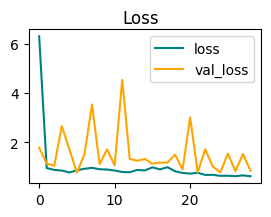

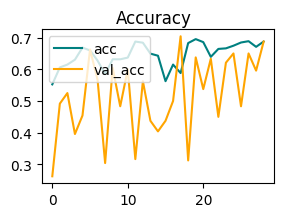

Fold Training Time: 0 hour(s) and 40 mins
Precision: 85.49618124961853  -  Recall: 46.666666865348816
Accuracy: 66.25000238418579
F1Score: Building 46.25850296020508 | Plant 74.22679901123047 | Road 79.99999237060547 | Vehicle 71.75572967529297
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/81f266f4-d62f-49a2-bd5f-8fc79ae6d934
Epoch 1/55
210/210 [==============================] - ETA: 0s - loss: 7.2043 - accuracy: 0.5530
Epoch 1: val_loss improved from inf to 2.70703, saving model to ./checkpoints/V4.1.3\FOLD-3
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-3\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-3\assets


210/210 [==============================] - 92s 412ms/step - loss: 7.2043 - accuracy: 0.5530 - val_loss: 2.7070 - val_accuracy: 0.2917 - lr: 0.0010
Epoch 2/55
210/210 [==============================] - ETA: 0s - loss: 1.0430 - accuracy: 0.6107
Epoch 2: val_loss improved from 2.70703 to 1.14218, saving model to ./checkpoints/V4.1.3\FOLD-3
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-3\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-3\assets


210/210 [==============================] - 87s 412ms/step - loss: 1.0430 - accuracy: 0.6107 - val_loss: 1.1422 - val_accuracy: 0.5250 - lr: 0.0010
Epoch 3/55
210/210 [==============================] - ETA: 0s - loss: 0.8881 - accuracy: 0.6107
Epoch 3: val_loss improved from 1.14218 to 0.64437, saving model to ./checkpoints/V4.1.3\FOLD-3
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-3\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-3\assets


210/210 [==============================] - 87s 416ms/step - loss: 0.8881 - accuracy: 0.6107 - val_loss: 0.6444 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 4/55
210/210 [==============================] - ETA: 0s - loss: 0.8045 - accuracy: 0.6690
Epoch 4: val_loss did not improve from 0.64437
210/210 [==============================] - 81s 384ms/step - loss: 0.8045 - accuracy: 0.6690 - val_loss: 0.8020 - val_accuracy: 0.7458 - lr: 0.0010
Epoch 5/55
210/210 [==============================] - ETA: 0s - loss: 0.7685 - accuracy: 0.6774
Epoch 5: val_loss did not improve from 0.64437
210/210 [==============================] - 82s 389ms/step - loss: 0.7685 - accuracy: 0.6774 - val_loss: 1.2539 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 6/55
210/210 [==============================] - ETA: 0s - loss: 0.8490 - accuracy: 0.6345
Epoch 6: val_loss did not improve from 0.64437
210/210 [==============================] - 81s 385ms/step - loss: 0.8490 - accuracy: 0.6345 - val_loss: 0.7896 - val_accuracy: 0.6

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-3\assets


210/210 [==============================] - 87s 413ms/step - loss: 0.5913 - accuracy: 0.7667 - val_loss: 0.5370 - val_accuracy: 0.7875 - lr: 6.0000e-04
Epoch 20/55
210/210 [==============================] - ETA: 0s - loss: 0.5237 - accuracy: 0.7970
Epoch 20: val_loss did not improve from 0.53704
210/210 [==============================] - 81s 385ms/step - loss: 0.5237 - accuracy: 0.7970 - val_loss: 0.6196 - val_accuracy: 0.7500 - lr: 6.0000e-04
Epoch 21/55
210/210 [==============================] - ETA: 0s - loss: 0.5741 - accuracy: 0.7798
Epoch 21: val_loss did not improve from 0.53704
210/210 [==============================] - 81s 384ms/step - loss: 0.5741 - accuracy: 0.7798 - val_loss: 0.5594 - val_accuracy: 0.7958 - lr: 6.0000e-04
Epoch 22/55
210/210 [==============================] - ETA: 0s - loss: 0.5484 - accuracy: 0.7756
Epoch 22: val_loss did not improve from 0.53704
210/210 [==============================] - 80s 383ms/step - loss: 0.5484 - accuracy: 0.7756 - val_loss: 1.3422 -

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-3\assets


210/210 [==============================] - 86s 410ms/step - loss: 0.5533 - accuracy: 0.7702 - val_loss: 0.3893 - val_accuracy: 0.8500 - lr: 6.0000e-04
Epoch 24/55
210/210 [==============================] - ETA: 0s - loss: 0.5394 - accuracy: 0.7857
Epoch 24: val_loss did not improve from 0.38928
210/210 [==============================] - 81s 383ms/step - loss: 0.5394 - accuracy: 0.7857 - val_loss: 0.8983 - val_accuracy: 0.6167 - lr: 6.0000e-04
Epoch 25/55
210/210 [==============================] - ETA: 0s - loss: 0.6276 - accuracy: 0.7512
Epoch 25: val_loss did not improve from 0.38928
210/210 [==============================] - 81s 384ms/step - loss: 0.6276 - accuracy: 0.7512 - val_loss: 0.5319 - val_accuracy: 0.8208 - lr: 6.0000e-04
Epoch 26/55
210/210 [==============================] - ETA: 0s - loss: 0.4773 - accuracy: 0.8167
Epoch 26: val_loss did not improve from 0.38928
210/210 [==============================] - 81s 384ms/step - loss: 0.4773 - accuracy: 0.8167 - val_loss: 0.5500 -

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-3\assets


210/210 [==============================] - 86s 411ms/step - loss: 0.3905 - accuracy: 0.8387 - val_loss: 0.3511 - val_accuracy: 0.8667 - lr: 3.6000e-04
Epoch 45/55
210/210 [==============================] - ETA: 0s - loss: 0.3927 - accuracy: 0.8470
Epoch 45: val_loss did not improve from 0.35113
210/210 [==============================] - 81s 383ms/step - loss: 0.3927 - accuracy: 0.8470 - val_loss: 0.4135 - val_accuracy: 0.8250 - lr: 3.6000e-04
Epoch 46/55
210/210 [==============================] - ETA: 0s - loss: 0.4108 - accuracy: 0.8542
Epoch 46: val_loss did not improve from 0.35113
210/210 [==============================] - 81s 385ms/step - loss: 0.4108 - accuracy: 0.8542 - val_loss: 0.4443 - val_accuracy: 0.8250 - lr: 3.6000e-04
Epoch 47/55
210/210 [==============================] - ETA: 0s - loss: 0.4010 - accuracy: 0.8494
Epoch 47: val_loss did not improve from 0.35113
210/210 [==============================] - 81s 384ms/step - loss: 0.4010 - accuracy: 0.8494 - val_loss: 0.4302 -

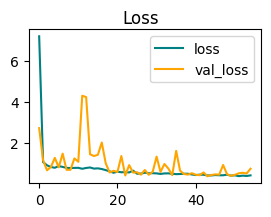

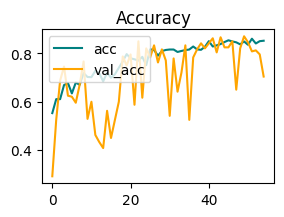

Fold Training Time: 1 hour(s) and 14 mins
Precision: 89.49771523475647  -  Recall: 81.66666626930237
Accuracy: 86.66666746139526
F1Score: Building 76.5217514038086 | Plant 92.06349182128906 | Road 96.61016845703125 | Vehicle 80.99173736572266
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/11a1a9db-f8d4-4c7d-b40f-5f0381079c9a
Epoch 1/55
210/210 [==============================] - ETA: 0s - loss: 6.3835 - accuracy: 0.5452
Epoch 1: val_loss improved from inf to 1.78308, saving model to ./checkpoints/V4.1.3\FOLD-4
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-4\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-4\assets


210/210 [==============================] - 94s 420ms/step - loss: 6.3835 - accuracy: 0.5452 - val_loss: 1.7831 - val_accuracy: 0.4208 - lr: 0.0010
Epoch 2/55
210/210 [==============================] - ETA: 0s - loss: 0.9327 - accuracy: 0.6077
Epoch 2: val_loss improved from 1.78308 to 0.76438, saving model to ./checkpoints/V4.1.3\FOLD-4
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-4\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-4\assets


210/210 [==============================] - 86s 410ms/step - loss: 0.9327 - accuracy: 0.6077 - val_loss: 0.7644 - val_accuracy: 0.6500 - lr: 0.0010
Epoch 3/55
210/210 [==============================] - ETA: 0s - loss: 0.8368 - accuracy: 0.6250
Epoch 3: val_loss did not improve from 0.76438
210/210 [==============================] - 80s 383ms/step - loss: 0.8368 - accuracy: 0.6250 - val_loss: 0.8415 - val_accuracy: 0.7083 - lr: 0.0010
Epoch 4/55
210/210 [==============================] - ETA: 0s - loss: 0.8555 - accuracy: 0.6375
Epoch 4: val_loss did not improve from 0.76438
210/210 [==============================] - 80s 382ms/step - loss: 0.8555 - accuracy: 0.6375 - val_loss: 1.7510 - val_accuracy: 0.3583 - lr: 0.0010
Epoch 5/55
210/210 [==============================] - ETA: 0s - loss: 0.8114 - accuracy: 0.6345
Epoch 5: val_loss did not improve from 0.76438
210/210 [==============================] - 80s 382ms/step - loss: 0.8114 - accuracy: 0.6345 - val_loss: 2.1834 - val_accuracy: 0.4

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-4\assets


210/210 [==============================] - 87s 415ms/step - loss: 0.6972 - accuracy: 0.6780 - val_loss: 0.7597 - val_accuracy: 0.7417 - lr: 6.0000e-04
Epoch 20/55
210/210 [==============================] - ETA: 0s - loss: 0.6159 - accuracy: 0.7667
Epoch 20: val_loss did not improve from 0.75970
210/210 [==============================] - 80s 382ms/step - loss: 0.6159 - accuracy: 0.7667 - val_loss: 0.7666 - val_accuracy: 0.8042 - lr: 6.0000e-04
Epoch 21/55
210/210 [==============================] - ETA: 0s - loss: 0.6268 - accuracy: 0.7554
Epoch 21: val_loss did not improve from 0.75970
210/210 [==============================] - 80s 382ms/step - loss: 0.6268 - accuracy: 0.7554 - val_loss: 1.2048 - val_accuracy: 0.7583 - lr: 6.0000e-04
Epoch 22/55
210/210 [==============================] - ETA: 0s - loss: 0.5626 - accuracy: 0.7738
Epoch 22: val_loss did not improve from 0.75970
210/210 [==============================] - 80s 380ms/step - loss: 0.5626 - accuracy: 0.7738 - val_loss: 3.3390 -

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-4\assets


210/210 [==============================] - 86s 409ms/step - loss: 0.5794 - accuracy: 0.7625 - val_loss: 0.7239 - val_accuracy: 0.7083 - lr: 6.0000e-04
Epoch 24/55
210/210 [==============================] - ETA: 0s - loss: 0.5918 - accuracy: 0.7530
Epoch 24: val_loss did not improve from 0.72390
210/210 [==============================] - 80s 381ms/step - loss: 0.5918 - accuracy: 0.7530 - val_loss: 5.6495 - val_accuracy: 0.5292 - lr: 6.0000e-04
Epoch 25/55
210/210 [==============================] - ETA: 0s - loss: 0.6884 - accuracy: 0.7250
Epoch 25: val_loss did not improve from 0.72390
210/210 [==============================] - 80s 381ms/step - loss: 0.6884 - accuracy: 0.7250 - val_loss: 0.8056 - val_accuracy: 0.7708 - lr: 6.0000e-04
Epoch 26/55
210/210 [==============================] - ETA: 0s - loss: 0.5756 - accuracy: 0.7726
Epoch 26: val_loss improved from 0.72390 to 0.47861, saving model to ./checkpoints/V4.1.3\FOLD-4
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-4\

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-4\assets


210/210 [==============================] - 86s 409ms/step - loss: 0.5756 - accuracy: 0.7726 - val_loss: 0.4786 - val_accuracy: 0.8625 - lr: 6.0000e-04
Epoch 27/55
210/210 [==============================] - ETA: 0s - loss: 0.5373 - accuracy: 0.7845
Epoch 27: val_loss did not improve from 0.47861
210/210 [==============================] - 80s 380ms/step - loss: 0.5373 - accuracy: 0.7845 - val_loss: 0.8111 - val_accuracy: 0.7333 - lr: 6.0000e-04
Epoch 28/55
210/210 [==============================] - ETA: 0s - loss: 0.5512 - accuracy: 0.7869
Epoch 28: val_loss did not improve from 0.47861
210/210 [==============================] - 80s 382ms/step - loss: 0.5512 - accuracy: 0.7869 - val_loss: 1.0994 - val_accuracy: 0.6292 - lr: 6.0000e-04
Epoch 29/55
210/210 [==============================] - ETA: 0s - loss: 0.5825 - accuracy: 0.7815
Epoch 29: val_loss did not improve from 0.47861
210/210 [==============================] - 80s 380ms/step - loss: 0.5825 - accuracy: 0.7815 - val_loss: 0.8801 -

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-4\assets


210/210 [==============================] - 86s 410ms/step - loss: 0.5031 - accuracy: 0.8065 - val_loss: 0.4136 - val_accuracy: 0.8792 - lr: 6.0000e-04
Epoch 38/55
210/210 [==============================] - ETA: 0s - loss: 0.5083 - accuracy: 0.7994
Epoch 38: val_loss improved from 0.41358 to 0.40737, saving model to ./checkpoints/V4.1.3\FOLD-4
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-4\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-4\assets


210/210 [==============================] - 86s 408ms/step - loss: 0.5083 - accuracy: 0.7994 - val_loss: 0.4074 - val_accuracy: 0.8708 - lr: 6.0000e-04
Epoch 39/55
210/210 [==============================] - ETA: 0s - loss: 0.4751 - accuracy: 0.8054
Epoch 39: val_loss did not improve from 0.40737
210/210 [==============================] - 80s 380ms/step - loss: 0.4751 - accuracy: 0.8054 - val_loss: 1.1059 - val_accuracy: 0.5875 - lr: 6.0000e-04
Epoch 40/55
210/210 [==============================] - ETA: 0s - loss: 0.4892 - accuracy: 0.8065
Epoch 40: val_loss did not improve from 0.40737
210/210 [==============================] - 80s 380ms/step - loss: 0.4892 - accuracy: 0.8065 - val_loss: 2.8965 - val_accuracy: 0.5250 - lr: 6.0000e-04
Epoch 41/55
210/210 [==============================] - ETA: 0s - loss: 0.4540 - accuracy: 0.8107
Epoch 41: val_loss did not improve from 0.40737
210/210 [==============================] - 80s 383ms/step - loss: 0.4540 - accuracy: 0.8107 - val_loss: 0.8421 -

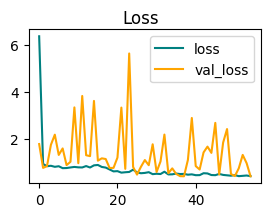

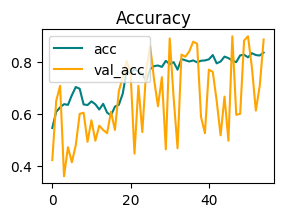

Fold Training Time: 1 hour(s) and 14 mins
Precision: 89.0350878238678  -  Recall: 84.58333611488342
Accuracy: 87.08333373069763
F1Score: Building 80.3149642944336 | Plant 91.47286224365234 | Road 95.7983169555664 | Vehicle 79.99999237060547
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/47a79cc7-ca71-4260-ad55-e8f31fb436fe
Epoch 1/55
210/210 [==============================] - ETA: 0s - loss: 7.7355 - accuracy: 0.5536
Epoch 1: val_loss improved from inf to 2.44871, saving model to ./checkpoints/V4.1.3\FOLD-5
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-5\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-5\assets


210/210 [==============================] - 98s 449ms/step - loss: 7.7355 - accuracy: 0.5536 - val_loss: 2.4487 - val_accuracy: 0.2750 - lr: 0.0010
Epoch 2/55
210/210 [==============================] - ETA: 0s - loss: 1.1283 - accuracy: 0.5958
Epoch 2: val_loss improved from 2.44871 to 0.84525, saving model to ./checkpoints/V4.1.3\FOLD-5
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-5\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-5\assets


210/210 [==============================] - 96s 458ms/step - loss: 1.1283 - accuracy: 0.5958 - val_loss: 0.8452 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 3/55
210/210 [==============================] - ETA: 0s - loss: 0.8735 - accuracy: 0.6190
Epoch 3: val_loss did not improve from 0.84525
210/210 [==============================] - 88s 417ms/step - loss: 0.8735 - accuracy: 0.6190 - val_loss: 1.5001 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 4/55
210/210 [==============================] - ETA: 0s - loss: 0.8987 - accuracy: 0.6667
Epoch 4: val_loss improved from 0.84525 to 0.72671, saving model to ./checkpoints/V4.1.3\FOLD-5
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-5\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-5\assets


210/210 [==============================] - 91s 434ms/step - loss: 0.8987 - accuracy: 0.6667 - val_loss: 0.7267 - val_accuracy: 0.7042 - lr: 0.0010
Epoch 5/55
210/210 [==============================] - ETA: 0s - loss: 0.7759 - accuracy: 0.6821
Epoch 5: val_loss did not improve from 0.72671
210/210 [==============================] - 85s 407ms/step - loss: 0.7759 - accuracy: 0.6821 - val_loss: 0.9524 - val_accuracy: 0.7375 - lr: 0.0010
Epoch 6/55
210/210 [==============================] - ETA: 0s - loss: 0.7605 - accuracy: 0.6815
Epoch 6: val_loss did not improve from 0.72671
210/210 [==============================] - 85s 406ms/step - loss: 0.7605 - accuracy: 0.6815 - val_loss: 1.5489 - val_accuracy: 0.5250 - lr: 0.0010
Epoch 7/55
210/210 [==============================] - ETA: 0s - loss: 0.7587 - accuracy: 0.6899
Epoch 7: val_loss did not improve from 0.72671
210/210 [==============================] - 85s 405ms/step - loss: 0.7587 - accuracy: 0.6899 - val_loss: 1.0071 - val_accuracy: 0.6

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-5\assets


210/210 [==============================] - 92s 437ms/step - loss: 0.8269 - accuracy: 0.6571 - val_loss: 0.5366 - val_accuracy: 0.8083 - lr: 0.0010
Epoch 9/55
210/210 [==============================] - ETA: 0s - loss: 0.8515 - accuracy: 0.6339
Epoch 9: val_loss did not improve from 0.53665
210/210 [==============================] - 85s 406ms/step - loss: 0.8515 - accuracy: 0.6339 - val_loss: 1.1003 - val_accuracy: 0.5208 - lr: 0.0010
Epoch 10/55
210/210 [==============================] - ETA: 0s - loss: 0.8069 - accuracy: 0.6726
Epoch 10: val_loss did not improve from 0.53665
210/210 [==============================] - 85s 404ms/step - loss: 0.8069 - accuracy: 0.6726 - val_loss: 0.7631 - val_accuracy: 0.7125 - lr: 0.0010
Epoch 11/55
210/210 [==============================] - ETA: 0s - loss: 0.8078 - accuracy: 0.6571
Epoch 11: val_loss did not improve from 0.53665
210/210 [==============================] - 85s 405ms/step - loss: 0.8078 - accuracy: 0.6571 - val_loss: 0.6611 - val_accuracy:

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-5\assets


210/210 [==============================] - 91s 434ms/step - loss: 0.6652 - accuracy: 0.7173 - val_loss: 0.5178 - val_accuracy: 0.8208 - lr: 0.0010
Epoch 24/55
210/210 [==============================] - ETA: 0s - loss: 0.6033 - accuracy: 0.7446
Epoch 24: val_loss did not improve from 0.51778
210/210 [==============================] - 85s 405ms/step - loss: 0.6033 - accuracy: 0.7446 - val_loss: 1.0167 - val_accuracy: 0.6625 - lr: 0.0010
Epoch 25/55
210/210 [==============================] - ETA: 0s - loss: 0.6293 - accuracy: 0.7464
Epoch 25: val_loss improved from 0.51778 to 0.45542, saving model to ./checkpoints/V4.1.3\FOLD-5
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-5\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-5\assets


210/210 [==============================] - 90s 431ms/step - loss: 0.6293 - accuracy: 0.7464 - val_loss: 0.4554 - val_accuracy: 0.8542 - lr: 0.0010
Epoch 26/55
210/210 [==============================] - ETA: 0s - loss: 0.5850 - accuracy: 0.7589
Epoch 26: val_loss improved from 0.45542 to 0.44653, saving model to ./checkpoints/V4.1.3\FOLD-5
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-5\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-5\assets


210/210 [==============================] - 91s 435ms/step - loss: 0.5850 - accuracy: 0.7589 - val_loss: 0.4465 - val_accuracy: 0.8375 - lr: 0.0010
Epoch 27/55
210/210 [==============================] - ETA: 0s - loss: 0.5881 - accuracy: 0.7321
Epoch 27: val_loss did not improve from 0.44653
210/210 [==============================] - 85s 405ms/step - loss: 0.5881 - accuracy: 0.7321 - val_loss: 0.8466 - val_accuracy: 0.7083 - lr: 0.0010
Epoch 28/55
210/210 [==============================] - ETA: 0s - loss: 0.5843 - accuracy: 0.7530
Epoch 28: val_loss did not improve from 0.44653
210/210 [==============================] - 85s 405ms/step - loss: 0.5843 - accuracy: 0.7530 - val_loss: 1.5666 - val_accuracy: 0.6042 - lr: 0.0010
Epoch 29/55
210/210 [==============================] - ETA: 0s - loss: 0.5959 - accuracy: 0.7619
Epoch 29: val_loss did not improve from 0.44653
210/210 [==============================] - 86s 411ms/step - loss: 0.5959 - accuracy: 0.7619 - val_loss: 0.6447 - val_accurac

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-5\assets


210/210 [==============================] - 91s 432ms/step - loss: 0.5130 - accuracy: 0.7988 - val_loss: 0.4139 - val_accuracy: 0.8667 - lr: 0.0010
Epoch 40/55
210/210 [==============================] - ETA: 0s - loss: 0.4887 - accuracy: 0.7887
Epoch 40: val_loss improved from 0.41395 to 0.33523, saving model to ./checkpoints/V4.1.3\FOLD-5
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-5\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-5\assets


210/210 [==============================] - 92s 439ms/step - loss: 0.4887 - accuracy: 0.7887 - val_loss: 0.3352 - val_accuracy: 0.8958 - lr: 0.0010
Epoch 41/55
210/210 [==============================] - ETA: 0s - loss: 0.4759 - accuracy: 0.8101
Epoch 41: val_loss did not improve from 0.33523
210/210 [==============================] - 85s 405ms/step - loss: 0.4759 - accuracy: 0.8101 - val_loss: 0.8660 - val_accuracy: 0.6750 - lr: 0.0010
Epoch 42/55
210/210 [==============================] - ETA: 0s - loss: 0.5142 - accuracy: 0.8048
Epoch 42: val_loss did not improve from 0.33523
210/210 [==============================] - 85s 406ms/step - loss: 0.5142 - accuracy: 0.8048 - val_loss: 0.7251 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 43/55
210/210 [==============================] - ETA: 0s - loss: 0.5393 - accuracy: 0.7756
Epoch 43: val_loss did not improve from 0.33523
210/210 [==============================] - 85s 406ms/step - loss: 0.5393 - accuracy: 0.7756 - val_loss: 0.9005 - val_accurac

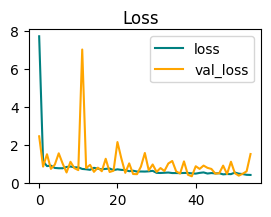

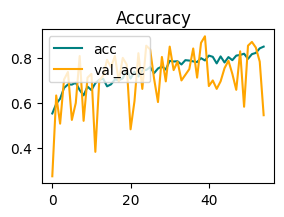

Fold Training Time: 1 hour(s) and 20 mins
Precision: 90.67796468734741  -  Recall: 89.16666507720947
Accuracy: 89.58333134651184
F1Score: Building 83.05084991455078 | Plant 95.0 | Road 91.89189147949219 | Vehicle 88.54961395263672
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/a9b03936-540b-4f6a-a58e-13e53c96aad6
Epoch 1/55
210/210 [==============================] - ETA: 0s - loss: 7.4632 - accuracy: 0.5333
Epoch 1: val_loss improved from inf to 1.81253, saving model to ./checkpoints/V4.1.3\FOLD-6
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-6\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-6\assets


210/210 [==============================] - 98s 444ms/step - loss: 7.4632 - accuracy: 0.5333 - val_loss: 1.8125 - val_accuracy: 0.4500 - lr: 0.0010
Epoch 2/55
210/210 [==============================] - ETA: 0s - loss: 0.9676 - accuracy: 0.6083
Epoch 2: val_loss improved from 1.81253 to 0.99385, saving model to ./checkpoints/V4.1.3\FOLD-6
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-6\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-6\assets


210/210 [==============================] - 91s 436ms/step - loss: 0.9676 - accuracy: 0.6083 - val_loss: 0.9938 - val_accuracy: 0.5250 - lr: 0.0010
Epoch 3/55
210/210 [==============================] - ETA: 0s - loss: 0.9016 - accuracy: 0.6500
Epoch 3: val_loss did not improve from 0.99385
210/210 [==============================] - 85s 407ms/step - loss: 0.9016 - accuracy: 0.6500 - val_loss: 1.3525 - val_accuracy: 0.4083 - lr: 0.0010
Epoch 4/55
210/210 [==============================] - ETA: 0s - loss: 0.9022 - accuracy: 0.6375
Epoch 4: val_loss improved from 0.99385 to 0.63770, saving model to ./checkpoints/V4.1.3\FOLD-6
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-6\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-6\assets


210/210 [==============================] - 93s 444ms/step - loss: 0.9022 - accuracy: 0.6375 - val_loss: 0.6377 - val_accuracy: 0.7708 - lr: 0.0010
Epoch 5/55
210/210 [==============================] - ETA: 0s - loss: 0.8318 - accuracy: 0.6637
Epoch 5: val_loss did not improve from 0.63770
210/210 [==============================] - 86s 407ms/step - loss: 0.8318 - accuracy: 0.6637 - val_loss: 2.1461 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/55
210/210 [==============================] - ETA: 0s - loss: 0.8471 - accuracy: 0.6536
Epoch 6: val_loss did not improve from 0.63770
210/210 [==============================] - 86s 411ms/step - loss: 0.8471 - accuracy: 0.6536 - val_loss: 1.0060 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 7/55
210/210 [==============================] - ETA: 0s - loss: 0.8746 - accuracy: 0.6423
Epoch 7: val_loss did not improve from 0.63770
210/210 [==============================] - 85s 405ms/step - loss: 0.8746 - accuracy: 0.6423 - val_loss: 0.9291 - val_accuracy: 0.6

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-6\assets


210/210 [==============================] - 91s 435ms/step - loss: 0.5971 - accuracy: 0.7756 - val_loss: 0.5296 - val_accuracy: 0.8125 - lr: 6.0000e-04
Epoch 22/55
210/210 [==============================] - ETA: 0s - loss: 0.5361 - accuracy: 0.8024
Epoch 22: val_loss did not improve from 0.52956
210/210 [==============================] - 86s 409ms/step - loss: 0.5361 - accuracy: 0.8024 - val_loss: 0.8274 - val_accuracy: 0.7708 - lr: 6.0000e-04
Epoch 23/55
210/210 [==============================] - ETA: 0s - loss: 0.5625 - accuracy: 0.7905
Epoch 23: val_loss did not improve from 0.52956
210/210 [==============================] - 86s 407ms/step - loss: 0.5625 - accuracy: 0.7905 - val_loss: 0.5418 - val_accuracy: 0.8208 - lr: 6.0000e-04
Epoch 24/55
210/210 [==============================] - ETA: 0s - loss: 0.5679 - accuracy: 0.7792
Epoch 24: val_loss did not improve from 0.52956
210/210 [==============================] - 85s 407ms/step - loss: 0.5679 - accuracy: 0.7792 - val_loss: 1.8229 -

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-6\assets


210/210 [==============================] - 91s 434ms/step - loss: 0.5507 - accuracy: 0.7964 - val_loss: 0.4877 - val_accuracy: 0.8417 - lr: 6.0000e-04
Epoch 27/55
210/210 [==============================] - ETA: 0s - loss: 0.4901 - accuracy: 0.8083
Epoch 27: val_loss did not improve from 0.48772
210/210 [==============================] - 86s 409ms/step - loss: 0.4901 - accuracy: 0.8083 - val_loss: 0.6718 - val_accuracy: 0.7792 - lr: 6.0000e-04
Epoch 28/55
210/210 [==============================] - ETA: 0s - loss: 0.5331 - accuracy: 0.8054
Epoch 28: val_loss did not improve from 0.48772
210/210 [==============================] - 86s 408ms/step - loss: 0.5331 - accuracy: 0.8054 - val_loss: 0.6087 - val_accuracy: 0.7792 - lr: 6.0000e-04
Epoch 29/55
210/210 [==============================] - ETA: 0s - loss: 0.5208 - accuracy: 0.8077
Epoch 29: val_loss did not improve from 0.48772
210/210 [==============================] - 85s 407ms/step - loss: 0.5208 - accuracy: 0.8077 - val_loss: 1.1164 -

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-6\assets


210/210 [==============================] - 92s 437ms/step - loss: 0.5081 - accuracy: 0.8060 - val_loss: 0.4683 - val_accuracy: 0.8542 - lr: 6.0000e-04
Epoch 42/55
210/210 [==============================] - ETA: 0s - loss: 0.4410 - accuracy: 0.8286
Epoch 42: val_loss did not improve from 0.46827
210/210 [==============================] - 85s 406ms/step - loss: 0.4410 - accuracy: 0.8286 - val_loss: 1.4535 - val_accuracy: 0.6667 - lr: 6.0000e-04
Epoch 43/55
210/210 [==============================] - ETA: 0s - loss: 0.4627 - accuracy: 0.8399
Epoch 43: val_loss improved from 0.46827 to 0.41562, saving model to ./checkpoints/V4.1.3\FOLD-6
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-6\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-6\assets


210/210 [==============================] - 91s 436ms/step - loss: 0.4627 - accuracy: 0.8399 - val_loss: 0.4156 - val_accuracy: 0.8750 - lr: 6.0000e-04
Epoch 44/55
210/210 [==============================] - ETA: 0s - loss: 0.4337 - accuracy: 0.8423
Epoch 44: val_loss did not improve from 0.41562
210/210 [==============================] - 85s 407ms/step - loss: 0.4337 - accuracy: 0.8423 - val_loss: 1.2082 - val_accuracy: 0.5625 - lr: 6.0000e-04
Epoch 45/55
210/210 [==============================] - ETA: 0s - loss: 0.4102 - accuracy: 0.8429
Epoch 45: val_loss did not improve from 0.41562
210/210 [==============================] - 85s 406ms/step - loss: 0.4102 - accuracy: 0.8429 - val_loss: 0.4394 - val_accuracy: 0.8750 - lr: 6.0000e-04
Epoch 46/55
210/210 [==============================] - ETA: 0s - loss: 0.4274 - accuracy: 0.8375
Epoch 46: val_loss did not improve from 0.41562
210/210 [==============================] - 85s 406ms/step - loss: 0.4274 - accuracy: 0.8375 - val_loss: 0.6950 -

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-6\assets


210/210 [==============================] - 91s 434ms/step - loss: 0.3971 - accuracy: 0.8530 - val_loss: 0.3690 - val_accuracy: 0.8708 - lr: 6.0000e-04
Epoch 55/55
210/210 [==============================] - ETA: 0s - loss: 0.3800 - accuracy: 0.8595
Epoch 55: val_loss improved from 0.36903 to 0.32517, saving model to ./checkpoints/V4.1.3\FOLD-6
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-6\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-6\assets


210/210 [==============================] - 92s 438ms/step - loss: 0.3800 - accuracy: 0.8595 - val_loss: 0.3252 - val_accuracy: 0.8917 - lr: 6.0000e-04


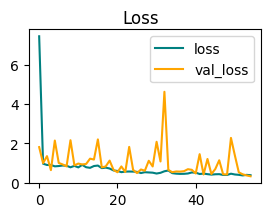

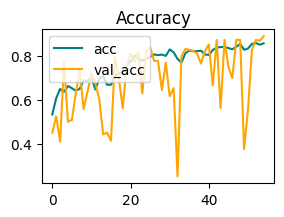

Fold Training Time: 1 hour(s) and 19 mins
Precision: 90.17093777656555  -  Recall: 87.91666626930237
Accuracy: 89.16666507720947
F1Score: Building 81.41593170166016 | Plant 95.7983169555664 | Road 95.0 | Vehicle 84.375
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/22da421b-915d-4ec3-9c42-42262a6d451d
Epoch 1/55
210/210 [==============================] - ETA: 0s - loss: 7.0633 - accuracy: 0.5601
Epoch 1: val_loss improved from inf to 1.52860, saving model to ./checkpoints/V4.1.3\FOLD-7
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-7\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-7\assets


210/210 [==============================] - 99s 453ms/step - loss: 7.0633 - accuracy: 0.5601 - val_loss: 1.5286 - val_accuracy: 0.3458 - lr: 0.0010
Epoch 2/55
210/210 [==============================] - ETA: 0s - loss: 0.9720 - accuracy: 0.6060
Epoch 2: val_loss improved from 1.52860 to 0.85093, saving model to ./checkpoints/V4.1.3\FOLD-7
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-7\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-7\assets


210/210 [==============================] - 105s 500ms/step - loss: 0.9720 - accuracy: 0.6060 - val_loss: 0.8509 - val_accuracy: 0.5917 - lr: 0.0010
Epoch 3/55
210/210 [==============================] - ETA: 0s - loss: 0.7861 - accuracy: 0.6750
Epoch 3: val_loss improved from 0.85093 to 0.69846, saving model to ./checkpoints/V4.1.3\FOLD-7
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-7\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-7\assets


210/210 [==============================] - 99s 472ms/step - loss: 0.7861 - accuracy: 0.6750 - val_loss: 0.6985 - val_accuracy: 0.7250 - lr: 0.0010
Epoch 4/55
210/210 [==============================] - ETA: 0s - loss: 0.7692 - accuracy: 0.6768
Epoch 4: val_loss did not improve from 0.69846
210/210 [==============================] - 87s 416ms/step - loss: 0.7692 - accuracy: 0.6768 - val_loss: 0.8273 - val_accuracy: 0.7083 - lr: 0.0010
Epoch 5/55
210/210 [==============================] - ETA: 0s - loss: 0.7542 - accuracy: 0.6887
Epoch 5: val_loss did not improve from 0.69846
210/210 [==============================] - 88s 417ms/step - loss: 0.7542 - accuracy: 0.6887 - val_loss: 1.3982 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 6/55
210/210 [==============================] - ETA: 0s - loss: 0.8000 - accuracy: 0.6839
Epoch 6: val_loss improved from 0.69846 to 0.68797, saving model to ./checkpoints/V4.1.3\FOLD-7
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-7\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-7\assets


210/210 [==============================] - 94s 450ms/step - loss: 0.8000 - accuracy: 0.6839 - val_loss: 0.6880 - val_accuracy: 0.6375 - lr: 0.0010
Epoch 7/55
210/210 [==============================] - ETA: 0s - loss: 0.7491 - accuracy: 0.7071
Epoch 7: val_loss did not improve from 0.68797
210/210 [==============================] - 88s 420ms/step - loss: 0.7491 - accuracy: 0.7071 - val_loss: 0.9284 - val_accuracy: 0.6083 - lr: 0.0010
Epoch 8/55
210/210 [==============================] - ETA: 0s - loss: 0.8290 - accuracy: 0.6327
Epoch 8: val_loss did not improve from 0.68797
210/210 [==============================] - 88s 419ms/step - loss: 0.8290 - accuracy: 0.6327 - val_loss: 0.8375 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 9/55
210/210 [==============================] - ETA: 0s - loss: 0.8689 - accuracy: 0.6125
Epoch 9: val_loss did not improve from 0.68797
210/210 [==============================] - 87s 417ms/step - loss: 0.8689 - accuracy: 0.6125 - val_loss: 2.6553 - val_accuracy: 0.4

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-7\assets


210/210 [==============================] - 93s 445ms/step - loss: 0.5176 - accuracy: 0.8149 - val_loss: 0.5130 - val_accuracy: 0.8292 - lr: 6.0000e-04
Epoch 25/55
210/210 [==============================] - ETA: 0s - loss: 0.5747 - accuracy: 0.8036
Epoch 25: val_loss did not improve from 0.51303
210/210 [==============================] - 87s 416ms/step - loss: 0.5747 - accuracy: 0.8036 - val_loss: 3.3669 - val_accuracy: 0.4917 - lr: 6.0000e-04
Epoch 26/55
210/210 [==============================] - ETA: 0s - loss: 0.5862 - accuracy: 0.7923
Epoch 26: val_loss improved from 0.51303 to 0.50947, saving model to ./checkpoints/V4.1.3\FOLD-7
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-7\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-7\assets


210/210 [==============================] - 93s 445ms/step - loss: 0.5862 - accuracy: 0.7923 - val_loss: 0.5095 - val_accuracy: 0.7958 - lr: 6.0000e-04
Epoch 27/55
210/210 [==============================] - ETA: 0s - loss: 0.5960 - accuracy: 0.7893
Epoch 27: val_loss did not improve from 0.50947
210/210 [==============================] - 88s 420ms/step - loss: 0.5960 - accuracy: 0.7893 - val_loss: 1.3404 - val_accuracy: 0.5500 - lr: 6.0000e-04
Epoch 28/55
210/210 [==============================] - ETA: 0s - loss: 0.5709 - accuracy: 0.7881
Epoch 28: val_loss did not improve from 0.50947
210/210 [==============================] - 87s 416ms/step - loss: 0.5709 - accuracy: 0.7881 - val_loss: 1.2031 - val_accuracy: 0.7125 - lr: 6.0000e-04
Epoch 29/55
210/210 [==============================] - ETA: 0s - loss: 0.5299 - accuracy: 0.7952
Epoch 29: val_loss did not improve from 0.50947
210/210 [==============================] - 87s 416ms/step - loss: 0.5299 - accuracy: 0.7952 - val_loss: 3.3051 -

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-7\assets


210/210 [==============================] - 94s 445ms/step - loss: 0.4278 - accuracy: 0.8548 - val_loss: 0.5056 - val_accuracy: 0.8167 - lr: 3.6000e-04
Epoch 46/55
210/210 [==============================] - ETA: 0s - loss: 0.3826 - accuracy: 0.8595
Epoch 46: val_loss did not improve from 0.50564
210/210 [==============================] - 88s 418ms/step - loss: 0.3826 - accuracy: 0.8595 - val_loss: 0.5367 - val_accuracy: 0.8333 - lr: 3.6000e-04
Epoch 47/55
210/210 [==============================] - ETA: 0s - loss: 0.3872 - accuracy: 0.8595
Epoch 47: val_loss did not improve from 0.50564
210/210 [==============================] - 88s 417ms/step - loss: 0.3872 - accuracy: 0.8595 - val_loss: 0.6928 - val_accuracy: 0.7375 - lr: 3.6000e-04
Epoch 48/55
210/210 [==============================] - ETA: 0s - loss: 0.4221 - accuracy: 0.8548
Epoch 48: val_loss improved from 0.50564 to 0.42497, saving model to ./checkpoints/V4.1.3\FOLD-7
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-7\

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.3\FOLD-7\assets


210/210 [==============================] - 94s 448ms/step - loss: 0.4221 - accuracy: 0.8548 - val_loss: 0.4250 - val_accuracy: 0.8542 - lr: 3.6000e-04
Epoch 49/55
210/210 [==============================] - ETA: 0s - loss: 0.4024 - accuracy: 0.8506
Epoch 49: val_loss did not improve from 0.42497
210/210 [==============================] - 88s 418ms/step - loss: 0.4024 - accuracy: 0.8506 - val_loss: 0.5486 - val_accuracy: 0.8042 - lr: 3.6000e-04
Epoch 50/55
210/210 [==============================] - ETA: 0s - loss: 0.3904 - accuracy: 0.8613
Epoch 50: val_loss did not improve from 0.42497
210/210 [==============================] - 88s 417ms/step - loss: 0.3904 - accuracy: 0.8613 - val_loss: 0.6952 - val_accuracy: 0.7458 - lr: 3.6000e-04
Epoch 51/55
210/210 [==============================] - ETA: 0s - loss: 0.3953 - accuracy: 0.8720
Epoch 51: val_loss did not improve from 0.42497
210/210 [==============================] - 88s 417ms/step - loss: 0.3953 - accuracy: 0.8720 - val_loss: 0.6775 -

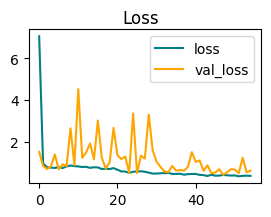

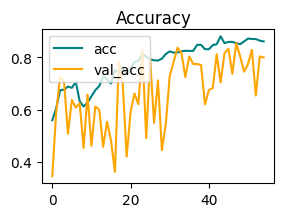

Fold Training Time: 1 hour(s) and 21 mins
Precision: 87.33624219894409  -  Recall: 83.33333134651184
Accuracy: 85.41666865348816
F1Score: Building 79.3388442993164 | Plant 91.60305786132812 | Road 90.26548767089844 | Vehicle 80.0
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
Total Training Time: 9 hour(s) and 47 mins


In [20]:
# ============================
# Log performance of each fold
# ============================

precisions = []
recalls = []
accuracies = []
f1_blds = []
f1_plants = []
f1_roads = []
f1_vhcls = []

counter = 0
start = perf_counter()
for train, test in kfold.split(train_x, train_y):
    start_fold = perf_counter()

    run = neptune.init_run(
        name= f"{model_name}-FOLD_{counter}",
        project=project_name,
        mode="offline"     # To prevent issue when internet sucks. Just manually sync it
    )  # your credentials

    run["parameters"] = params
    model = make_model(params)
    cat_y = tf.keras.utils.to_categorical(train_y)
    train_dataset = tf.data.Dataset.from_tensor_slices((train_x[train], cat_y[train]))
    train_fold = train_dataset.shuffle(buffer_size=train_dataset.cardinality(), seed=1).batch(params['batch_size'])
    
    test_dataset = tf.data.Dataset.from_tensor_slices((train_x[test], cat_y[test]))
    test_fold = test_dataset.shuffle(buffer_size=test_dataset.cardinality(), seed=1).batch(params['batch_size'])
    
    hist = model.fit(train_fold, 
                     validation_data=test_fold,
                     batch_size=params['batch_size'],
                     epochs=params['epochs'],
                     verbose=1,
                     callbacks=create_callbacks(counter))
    end_fold = perf_counter()

    # PLOTTING ==================================================
    run["fig-train_loss"].upload(plot_loss(hist))
    run["fig-train_acc"].upload(plot_acc(hist))
    
    # EVALUATING ==================================================
    model = tf.keras.models.load_model(checkpoint_path + str(counter))
    
    pre = Precision()
    rec = Recall()
    c_acc = CategoricalAccuracy()
    f1_score = F1Score()
    for batch in test_fold.as_numpy_iterator():
        X, y = batch
        yhat = model.predict(X, verbose=0)
        f1_score.update_state(y, yhat)
        pre.update_state(y, yhat)
        rec.update_state(y, yhat)
        c_acc.update_state(y, yhat)
        
    precisions.append(pre.result().numpy() * 100)
    recalls.append(rec.result().numpy() * 100)
    accuracies.append(c_acc.result().numpy() * 100)
    f1_s = f1_score.result().numpy() * 100
    
    f1_blds.append(f1_s[0])
    f1_plants.append(f1_s[1])
    f1_roads.append(f1_s[2])
    f1_vhcls.append(f1_s[3])
    
    run["eval/ACC/"] = accuracies[counter]
    run["eval/REC/"] = recalls[counter]
    run["eval/PRE/"] = precisions[counter]
    run["eval/F1-Bld"] = f1_blds[counter]
    run["eval/F1-Plant"] = f1_plants[counter]
    run["eval/F1-Road"] = f1_roads[counter]
    run["eval/F1-Vhcl"] = f1_vhcls[counter]

    # SAVE MODEL TO NEPTUNE AI =======================================
    model_save_path = f"./models/V4-1-3_Fold-{counter}.keras"
    model.save(model_save_path)
    run['/checkpoint/model'].upload(model_save_path)
    
    # PRINTING RESULTS ===========================================
    print(f'Fold Training Time: {math.floor((end_fold-start_fold)/3600) } hour(s) and {math.floor((end_fold-start_fold)/60)%60} mins')
    print(f'Precision: {precisions[counter]}  -  Recall: {recalls[counter]}')
    print(f'Accuracy: {accuracies[counter]}')
    print(f'F1Score: Building {f1_blds[counter]} | Plant {f1_plants[counter]} | Road {f1_roads[counter]} | Vehicle {f1_vhcls[counter]}')
    
    run.stop()
    
    counter += 1

end = perf_counter()

print(f'Total Training Time: {math.floor((end-start)/3600) } hour(s) and {math.floor((end-start)/60)%60} mins')

# Get Average Performance of Model

## Save to Neptune AI

In [21]:
run = neptune.init_run(
        name= f"{model_name}-AVG",
        project=project_name,
        mode='offline',
        # api_token=api_token, # Api token is saved in user's environemnt variables
    )  # your credentials

run["eval/PRE/"] = avg_rate(precisions)
run["eval/REC/"] = avg_rate(recalls)
run["eval/ACC/"] = avg_rate(accuracies)
run["eval/F1-Bld"] = avg_rate(f1_blds)
run["eval/F1-Plant"] = avg_rate(f1_plants)
run["eval/F1-Road"] = avg_rate(f1_roads)
run["eval/F1-Vhcl"] = avg_rate(f1_vhcls)

run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: offline/74b73db5-451b-4e93-9ece-b4a7bdcad585
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!


## Save to Tensorboard

In [22]:
# Command to access TensorBoard HParams:

# tensorboard --logdir PATH/logs/hparam_tuning
with tf.summary.create_file_writer(f'./logs/hparam_tuning/{model_name}').as_default():
    hparams = {
        'CONV_F1': 16,
        'CONV_F2': 32,
        'CONV_F3': 64,
        'DROPOUT': 0.2,
        'D_UNITS_1': 384,
        'DROPOUT': 0.2,
        'D_UNITS_2': 256,
    }
    hp.hparams(hparams)
    tf.summary.scalar('PRE', avg_rate(precisions), step=1)
    tf.summary.scalar('REC', avg_rate(recalls), step=1)
    tf.summary.scalar('ACC', avg_rate(accuracies), step=1)
    tf.summary.scalar('F1 - Building', avg_rate(f1_blds), step=1)
    tf.summary.scalar('F1 - Plant', avg_rate(f1_plants), step=1)
    tf.summary.scalar('F1 - Road', avg_rate(f1_roads), step=1)
    tf.summary.scalar('F1 - Vehicle', avg_rate(f1_vhcls), step=1)

# Asd

# Others

In [ ]:
model= make_model()
model.fit(
    x_train,
    y_train,
    validation_data=(x_test,y_test),
    epochs=params["epochs"],
    batch_size=params["batch_size"],
    callbacks=create_callbacks(0),
)

In [ ]:
true_test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
true_test_set = true_test_dataset.shuffle(buffer_size=true_test_dataset.cardinality(), seed=1).batch(64)

f1 = F1Score()
pre = Precision()
rec = Recall()
c_acc = CategoricalAccuracy()
for batch in true_test_set.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    yhat_max = []
    for i in yhat:
        maxed = np.argmax(i)
        yhat_max.append(maxed)
    yhat = np.array(yhat_max)
    f1.update_state(y, yhat)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    c_acc.update_state(y, yhat)


In [ ]:
run["eval/ACC/"] = float(c_acc.result().numpy() * 100)
run["eval/REC/"] = float(rec.result().numpy() * 100)
run["eval/PRE/"] = float(pre.result().numpy() * 100)


In [ ]:
run.stop()

In [ ]:
eval_metrics = model.evaluate(x_test, y_test, verbose=0)
for j, metric in enumerate(eval_metrics):
    run["eval/AVG-ACC/{}".format(model.metrics_names[j])] = metric

run.stop()

In [ ]:
for j, metric in enumerate(eval_metrics):
    print(model.metrics_names[j])

## Neptune AI Notes